#  Notebook 1 : Data Pipeline (T01-T04)

Ce notebook explore le pipeline de données du projet de trading GBP/USD :
- **T01** : Chargement des données brutes
- **T02** : Agrégation en bougies M15 (15 minutes)
- **T03** : Nettoyage des données
- **T04** : Analyse de qualité

---

##  Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

##  Chargement des données brutes (T01)

In [10]:
# Charger les données M15 pour 2022
df_raw = pd.read_csv('../data/processed/m15_2022.csv')

# Convertir l'index en datetime si nécessaire
if 'timestamp' in df_raw.columns:
    df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
    df_raw.set_index('timestamp', inplace=True)
elif 'timestamp_15m' in df_raw.columns:
    df_raw['timestamp_15m'] = pd.to_datetime(df_raw['timestamp_15m'])
    df_raw.set_index('timestamp_15m', inplace=True)

print(f"📊 Données brutes chargées")
print(f"   Lignes: {len(df_raw):,}")
print(f"   Colonnes: {list(df_raw.columns)}")
print(f"   Période: {df_raw.index[0]} → {df_raw.index[-1]}")

df_raw.head()

📊 Données brutes chargées
   Lignes: 24,913
   Colonnes: ['open_15m', 'high_15m', 'low_15m', 'close_15m', 'volume_15m', 'n_candles_m1']
   Période: 2022-01-02 17:00:00 → 2022-12-30 16:45:00


,open_15m,high_15m,low_15m,close_15m,volume_15m,n_candles_m1
timestamp_15m,,,,,,
2022-01-02 17:00:00,1.35199,1.35233,1.35199,1.35223,0,8
2022-01-02 17:15:00,1.35231,1.35253,1.35223,1.35241,0,9
2022-01-02 17:30:00,1.35223,1.35323,1.35223,1.35295,0,14
2022-01-02 17:45:00,1.35292,1.35319,1.35260,1.35269,0,15
2022-01-02 18:00:00,1.35287,1.35338,1.35257,1.35258,0,15


##  Agrégation en bougies M15 (T02)

Les données brutes sont agrégées en bougies de 15 minutes avec :
- **Open** : Premier prix de la période
- **High** : Prix le plus haut
- **Low** : Prix le plus bas
- **Close** : Dernier prix de la période
- **Volume** : Volume total (si disponible)

In [14]:
# Les données sont déjà agrégées, visualisons une journée
try:
    # Méthode 1 : Sélection par date string
    sample_day = df_raw.loc['2022-01-03']
except:
    # Méthode 2 : Filtrage manuel
    sample_day = df_raw[(df_raw.index >= '2022-01-03') & (df_raw.index < '2022-01-04')]

print(f"🕐 Bougies pour le 2022-01-03")
print(f"   Nombre de bougies: {len(sample_day)}")
print(f"   Une bougie toutes les 15 minutes")

sample_day[['open_15m', 'high_15m', 'low_15m', 'close_15m']].head(10)

🕐 Bougies pour le 2022-01-03
   Nombre de bougies: 96
   Une bougie toutes les 15 minutes


,open_15m,high_15m,low_15m,close_15m
timestamp_15m,,,,
2022-01-03 00:00:00,1.34980,1.35004,1.34970,1.34981
2022-01-03 00:15:00,1.34979,1.34995,1.34964,1.34968
2022-01-03 00:30:00,1.34967,1.34995,1.34950,1.34992
2022-01-03 00:45:00,1.34992,1.35002,1.34971,1.34982
2022-01-03 01:00:00,1.34983,1.35030,1.34982,1.35021
2022-01-03 01:15:00,1.35023,1.35024,1.34972,1.35004
2022-01-03 01:30:00,1.35003,1.35061,1.35001,1.35031
2022-01-03 01:45:00,1.35030,1.35078,1.35030,1.35053
2022-01-03 02:00:00,1.35057,1.35065,1.34963,1.35062


### Visualisation des bougies

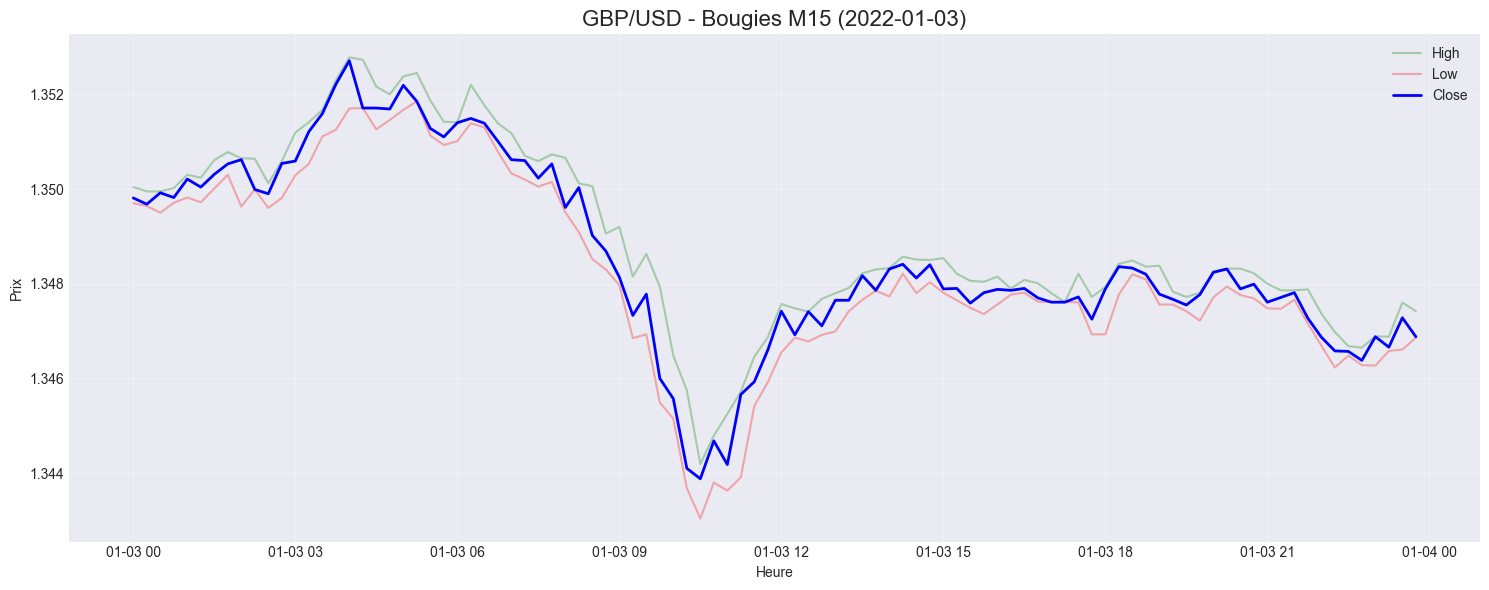

In [15]:
# Candlestick chart pour une journée
fig, ax = plt.subplots(figsize=(15, 6))

# Prix OHLC
ax.plot(sample_day.index, sample_day['high_15m'], label='High', alpha=0.3, color='green')
ax.plot(sample_day.index, sample_day['low_15m'], label='Low', alpha=0.3, color='red')
ax.plot(sample_day.index, sample_day['close_15m'], label='Close', linewidth=2, color='blue')

ax.set_title('GBP/USD - Bougies M15 (2022-01-03)', fontsize=16)
ax.set_xlabel('Heure')
ax.set_ylabel('Prix')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##  Nettoyage des données (T03)

Vérification de la qualité :
- Valeurs manquantes
- Doublons
- Valeurs aberrantes
- Cohérence OHLC

In [16]:
# Valeurs manquantes
print("🔍 Analyse de qualité")
print("\n1. Valeurs manquantes:")
print(df_raw.isnull().sum())

# Doublons
duplicates = df_raw.index.duplicated().sum()
print(f"\n2. Doublons: {duplicates}")

# Cohérence OHLC (High >= Low, etc.)
invalid_ohlc = (
    (df_raw['high_15m'] < df_raw['low_15m']) |
    (df_raw['high_15m'] < df_raw['open_15m']) |
    (df_raw['high_15m'] < df_raw['close_15m']) |
    (df_raw['low_15m'] > df_raw['open_15m']) |
    (df_raw['low_15m'] > df_raw['close_15m'])
).sum()
print(f"\n3. Incohérences OHLC: {invalid_ohlc}")

🔍 Analyse de qualité

1. Valeurs manquantes:
open_15m        0
high_15m        0
low_15m         0
close_15m       0
volume_15m      0
n_candles_m1    0
dtype: int64

2. Doublons: 0

3. Incohérences OHLC: 0


##  Statistiques descriptives (T04)

In [17]:
# Statistiques
print(" Statistiques descriptives\n")
df_raw[['open_15m', 'high_15m', 'low_15m', 'close_15m']].describe()

 Statistiques descriptives



,open_15m,high_15m,low_15m,close_15m
count,24913.000000,24913.000000,24913.000000,24913.000000
mean,1.236698,1.237299,1.236095,1.236691
std,0.076170,0.076005,0.076324,0.076167
min,1.039970,1.051140,1.032610,1.040000
25%,1.185100,1.185880,1.184260,1.185100
50%,1.222170,1.222730,1.221430,1.222170
75%,1.308200,1.308680,1.307690,1.308200
max,1.374630,1.374870,1.374000,1.374610


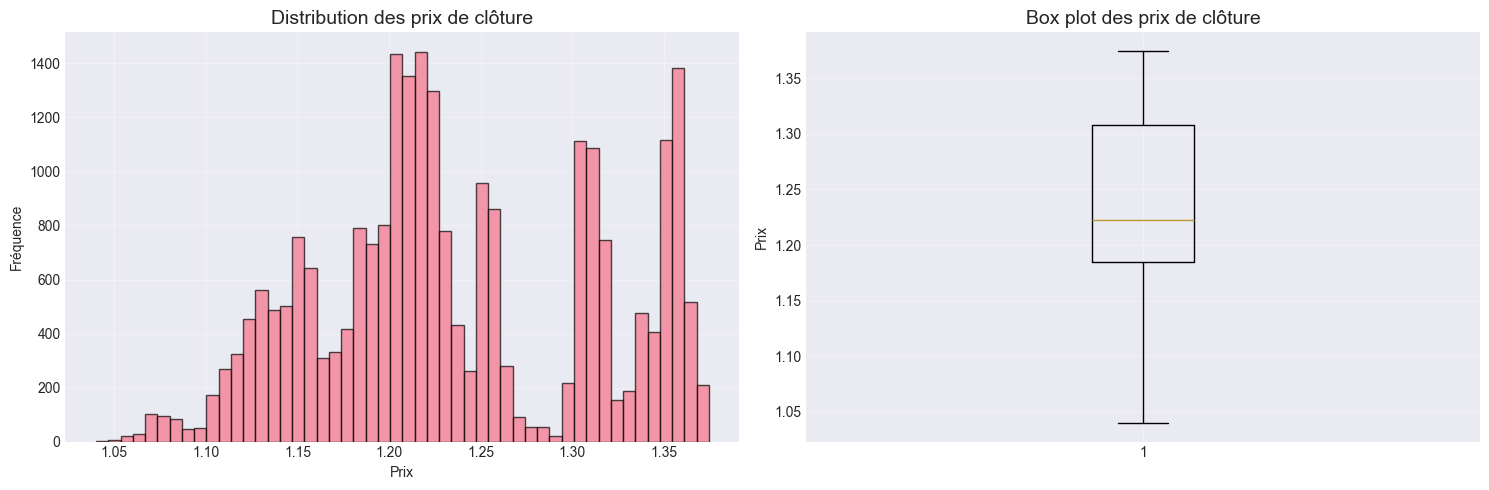

In [18]:
# Distribution des prix de clôture
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogramme
axes[0].hist(df_raw['close_15m'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution des prix de clôture', fontsize=14)
axes[0].set_xlabel('Prix')
axes[0].set_ylabel('Fréquence')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_raw['close_15m'])
axes[1].set_title('Box plot des prix de clôture', fontsize=14)
axes[1].set_ylabel('Prix')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##  Évolution du prix sur l'année

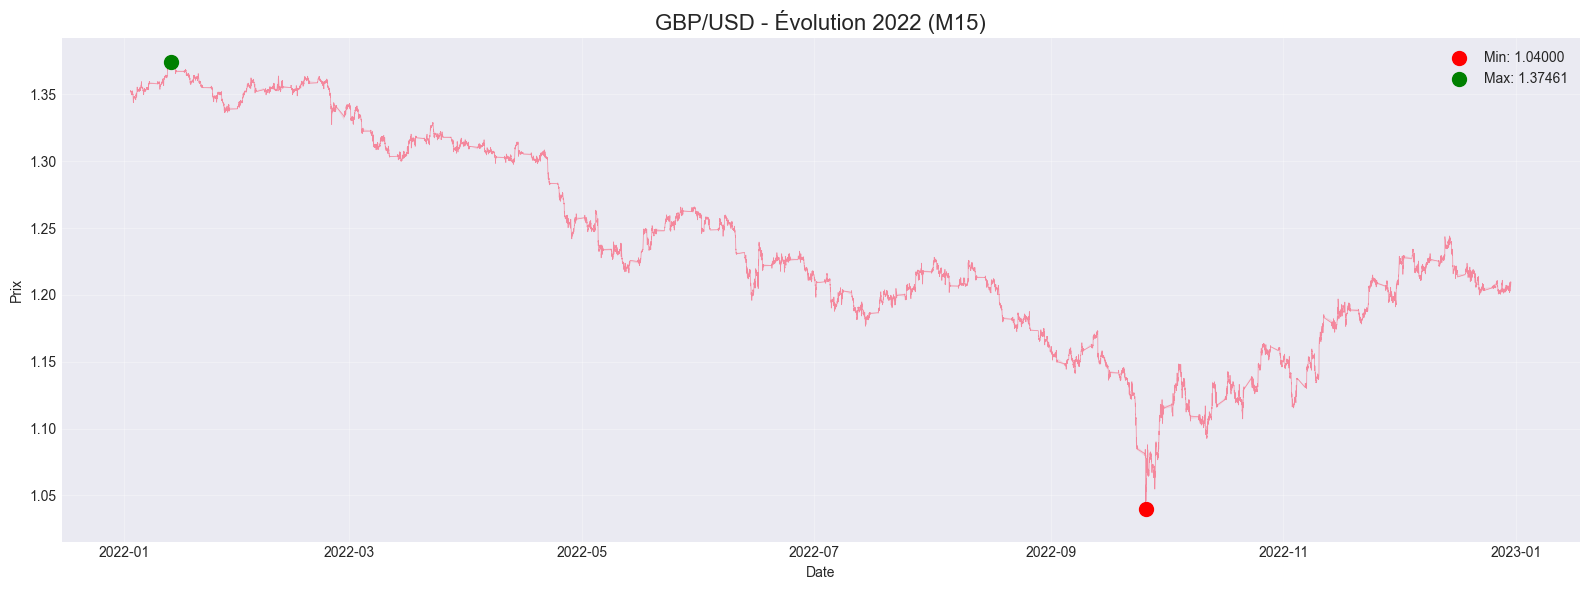


 Résumé 2022:
   Prix min: 1.04000 (2022-09-25 20:45:00)
   Prix max: 1.37461 (2022-01-13 05:00:00)
   Variation: -10.55%


In [19]:
# Prix sur toute l'année 2022
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df_raw.index, df_raw['close_15m'], linewidth=0.5, alpha=0.8)
ax.fill_between(df_raw.index, df_raw['low_15m'], df_raw['high_15m'], alpha=0.2)

ax.set_title('GBP/USD - Évolution 2022 (M15)', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Prix')
ax.grid(True, alpha=0.3)

# Calculer le min/max pour annotation
min_price = df_raw['close_15m'].min()
max_price = df_raw['close_15m'].max()
min_date = df_raw['close_15m'].idxmin()
max_date = df_raw['close_15m'].idxmax()

ax.scatter([min_date], [min_price], color='red', s=100, zorder=5, label=f'Min: {min_price:.5f}')
ax.scatter([max_date], [max_price], color='green', s=100, zorder=5, label=f'Max: {max_price:.5f}')

ax.legend()
plt.tight_layout()
plt.show()

print(f"\n Résumé 2022:")
print(f"   Prix min: {min_price:.5f} ({min_date})")
print(f"   Prix max: {max_price:.5f} ({max_date})")
print(f"   Variation: {((df_raw['close_15m'].iloc[-1] / df_raw['close_15m'].iloc[0]) - 1) * 100:.2f}%")

##  Analyse de la volatilité

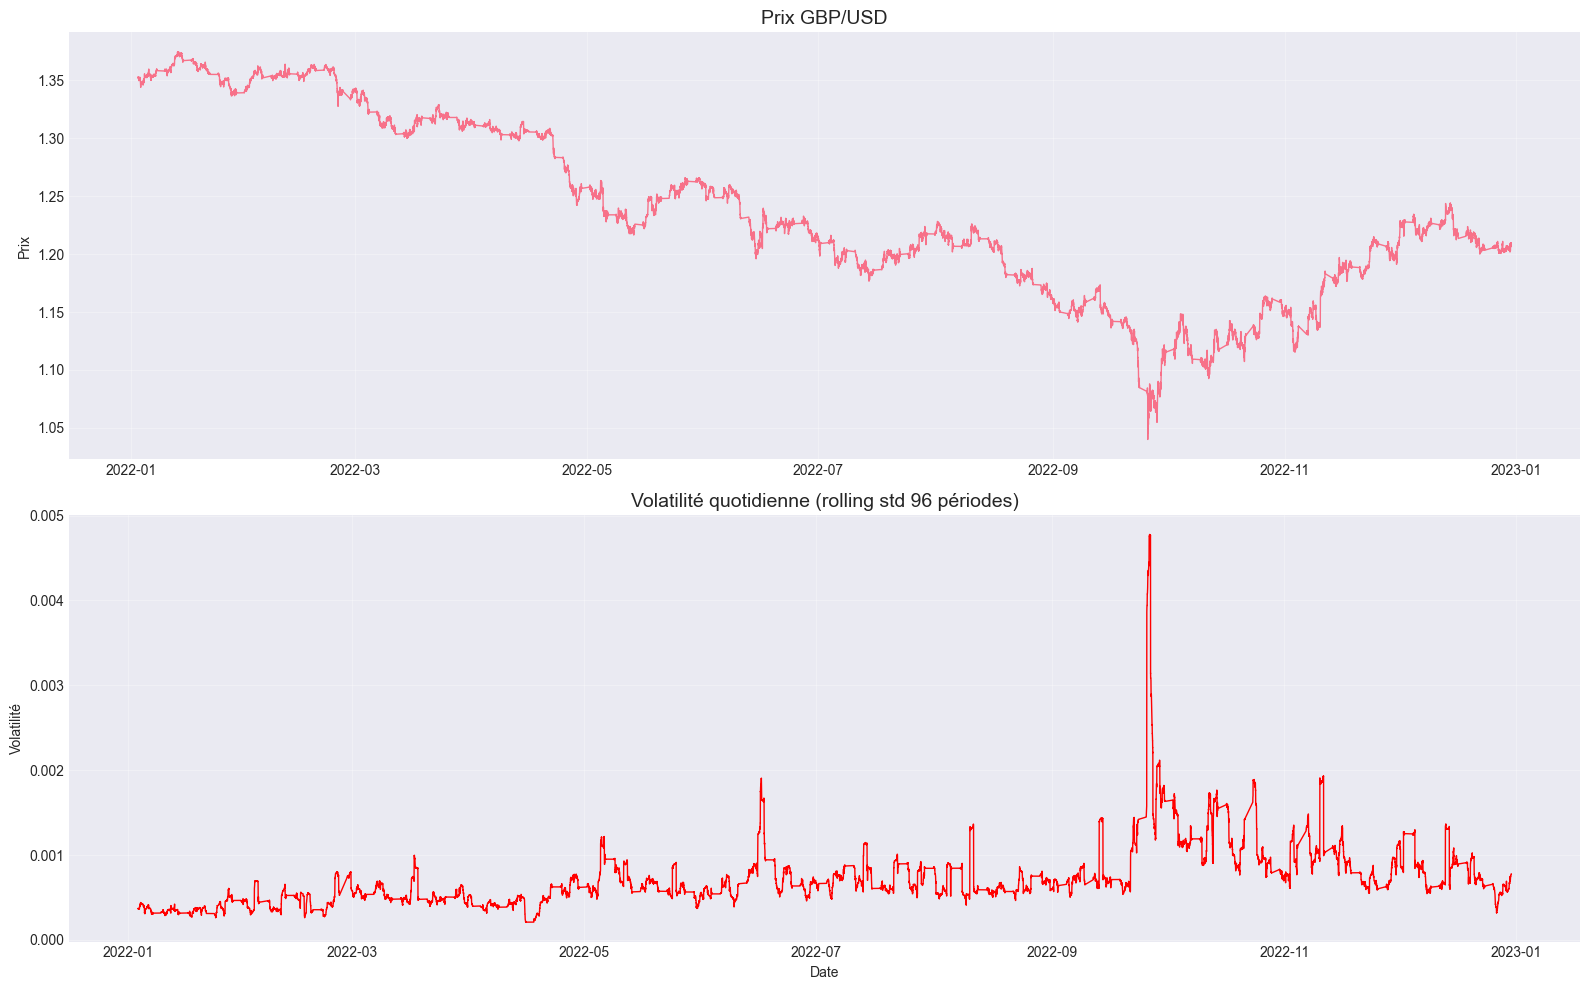

In [20]:
# Calculer les returns
df_raw['returns'] = df_raw['close_15m'].pct_change()
df_raw['log_returns'] = np.log(df_raw['close_15m'] / df_raw['close_15m'].shift(1))

# Volatilité quotidienne (std des returns sur 96 périodes = 1 jour)
df_raw['volatility_daily'] = df_raw['returns'].rolling(window=96).std()

# Visualisation
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Prix
axes[0].plot(df_raw.index, df_raw['close_15m'], linewidth=1)
axes[0].set_title('Prix GBP/USD', fontsize=14)
axes[0].set_ylabel('Prix')
axes[0].grid(True, alpha=0.3)

# Volatilité
axes[1].plot(df_raw.index, df_raw['volatility_daily'], color='red', linewidth=1)
axes[1].set_title('Volatilité quotidienne (rolling std 96 périodes)', fontsize=14)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volatilité')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ✅ Conclusion

Le pipeline de données (T01-T04) fournit :
- ✅ Données propres et cohérentes
- ✅ Format OHLC standard (bougies M15)
- ✅ Aucune valeur manquante
- ✅ Aucun doublon
- ✅ Qualité validée

Les données sont prêtes pour :
- **T05** : Feature engineering (indicateurs techniques)
- **T06** : Stratégies baseline
- **T07** : Modèles ML